In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os
from config import FLAGS
import pandas as pd

In [2]:
# Useful Constants

# Output classes to learn how to classify
LABELS = FLAGS.LABELS
DATASET_PATH_train = FLAGS.train_path
DATASET_PATH_test = FLAGS.test_path

X_train_path = DATASET_PATH_train + "X_train.txt"
X_test_path = DATASET_PATH_test + "X_test.txt"

y_train_path = DATASET_PATH_train + "Y_train.txt"
y_test_path = DATASET_PATH_test + "Y_test.txt"

n_steps = FLAGS.n_frames # 32 timesteps per series

In [3]:
# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ =np.array(
        [elem for elem in [
            row.replace('\n', '').split(' ') for row in file
        ]], 
        dtype=np.float32
    )

    file.close()
    blocks = int(len(X_) / n_steps)
    

    X_ = np.array(np.split(X_,blocks))
    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)

In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = FLAGS.n_features  # num input parameters per timestep

n_hidden = FLAGS.n_hiddens # Hidden layer num of features
n_classes = FLAGS.n_outputs 

#updated for learning-rate decay
# calculated as: decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = FLAGS.decaying_learning_rate
learning_rate = FLAGS.lr #used if decaying_learning_rate set to False
init_learning_rate = FLAGS.init_lr
decay_rate = FLAGS.decay_rate #the base of the exponential in the decay
decay_steps = FLAGS.decay_steps #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = FLAGS.lambda_loss_amount

training_iters = training_data_count*100 #FLAGS.epochs   # Loop 300 times on the dataset, ie 300 epochs
batch_size = FLAGS.batch_size
display_iter = FLAGS.display_iter  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")

(X shape, y shape, every X's mean, every X's standard deviation)
((10057, 1, 36), (3499, 1), 108.98817, 64.57691)

The dataset has not been preprocessed, is not normalised etc


In [5]:
X_train[0][0]

array([128.052,  29.805, 128.052,  52.987, 111.494,  56.299,  98.247,
        23.182, 118.117,   0.   , 144.61 ,  52.987, 157.857,  29.805,
       141.299,   3.312, 114.805, 135.779, 111.494, 195.39 , 108.182,
       251.688, 137.987, 135.779, 141.299, 198.701, 141.299, 255.   ,
       124.74 ,  23.182, 131.364,  26.494, 118.117,  29.805, 137.987,
        29.805], dtype=float32)

In [6]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = FLAGS.n_features  # num input parameters per timestep

n_hidden = FLAGS.n_hiddens # Hidden layer num of features
n_classes = FLAGS.n_outputs 

#updated for learning-rate decay
# calculated as: decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = FLAGS.decaying_learning_rate
learning_rate = FLAGS.lr #used if decaying_learning_rate set to False
init_learning_rate = FLAGS.init_lr
decay_rate = FLAGS.decay_rate #the base of the exponential in the decay
decay_steps = FLAGS.decay_steps #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = FLAGS.lambda_loss_amount

training_iters = training_data_count*100 #FLAGS.epochs   # Loop 300 times on the dataset, ie 300 epochs
batch_size = FLAGS.batch_size
display_iter = FLAGS.display_iter  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape)#, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")

(X shape, y shape, every X's mean, every X's standard deviation)
((10057, 1, 36), (3499, 1))

The dataset has not been preprocessed, is not normalised etc


In [7]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in list(range(batch_size)):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
#        print(_unsampled)
#        print(index)
#        print(_train[0][0])
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [8]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [9]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = list(range(0,len(X_train)))

while step * batch_size <= training_iters:
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = list(range(0,len(X_train)))
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
#     batch_ys=tf.expand_dims(batch_ys,0)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #80:  Learning rate = 0.005000:   Batch Loss = 3.342341, Accuracy = 0.262499988079
PERFORMANCE ON TEST SET:             Batch Loss = 3.16299676895, Accuracy = 0.135467275977
Iter #640:  Learning rate = 0.005000:   Batch Loss = 2.760847, Accuracy = 0.487500011921
PERFORMANCE ON TEST SET:             Batch Loss = 2.7448451519, Accuracy = 0.490997433662
Iter #1280:  Learning rate = 0.005000:   Batch Loss = 2.530897, Accuracy = 0.512499988079
PERFORMANCE ON TEST SET:             Batch Loss = 2.49742126465, Accuracy = 0.491283237934
Iter #1920:  Learning rate = 0.005000:   Batch Loss = 2.365692, Accuracy = 0.449999988079
PERFORMANCE ON TEST SET:             Batch Loss = 2.3015806675, Accuracy = 0.491283237934
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 2.236192, Accuracy = 0.487500011921
PERFORMANCE ON TEST SET:             Batch Loss = 2.22711610794, Accuracy = 0.491283237934
Iter #3200:  Learning rate = 0.005000:   Batch Loss = 1.952652, Accuracy = 0.600000023842
PERFORMANC

Iter #30080:  Learning rate = 0.005000:   Batch Loss = 1.464785, Accuracy = 0.47499999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.45908212662, Accuracy = 0.491283237934
Iter #30720:  Learning rate = 0.005000:   Batch Loss = 1.454368, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.44972658157, Accuracy = 0.491283237934
Iter #31360:  Learning rate = 0.005000:   Batch Loss = 1.423979, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4440574646, Accuracy = 0.491283237934
Iter #32000:  Learning rate = 0.005000:   Batch Loss = 1.372294, Accuracy = 0.600000023842
PERFORMANCE ON TEST SET:             Batch Loss = 1.45660066605, Accuracy = 0.491283237934
Iter #32640:  Learning rate = 0.005000:   Batch Loss = 1.388097, Accuracy = 0.537500023842
PERFORMANCE ON TEST SET:             Batch Loss = 1.42940270901, Accuracy = 0.491283237934
Iter #33280:  Learning rate = 0.005000:   Batch Loss = 1.388076, Accuracy = 0.600000023842
PERFORMANCE ON TEST 

Iter #59520:  Learning rate = 0.005000:   Batch Loss = 1.203667, Accuracy = 0.550000011921
PERFORMANCE ON TEST SET:             Batch Loss = 1.21786665916, Accuracy = 0.491283237934
Iter #60160:  Learning rate = 0.005000:   Batch Loss = 1.619515, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 1.56224131584, Accuracy = 0.287224918604
Iter #60800:  Learning rate = 0.005000:   Batch Loss = 1.312478, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.34117949009, Accuracy = 0.491283237934
Iter #61440:  Learning rate = 0.005000:   Batch Loss = 1.210857, Accuracy = 0.550000011921
PERFORMANCE ON TEST SET:             Batch Loss = 1.26893770695, Accuracy = 0.491283237934
Iter #62080:  Learning rate = 0.005000:   Batch Loss = 1.236948, Accuracy = 0.487500011921
PERFORMANCE ON TEST SET:             Batch Loss = 1.26032435894, Accuracy = 0.491283237934
Iter #62720:  Learning rate = 0.005000:   Batch Loss = 1.246767, Accuracy = 0.425000011921
PERFORMANCE ON TEST 

Iter #89600:  Learning rate = 0.005000:   Batch Loss = 1.093002, Accuracy = 0.47499999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.13090109825, Accuracy = 0.491283237934
Iter #90240:  Learning rate = 0.005000:   Batch Loss = 1.097141, Accuracy = 0.47499999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.12813448906, Accuracy = 0.491283237934
Iter #90880:  Learning rate = 0.005000:   Batch Loss = 1.108520, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.12638103962, Accuracy = 0.491283237934
Iter #91520:  Learning rate = 0.005000:   Batch Loss = 1.142424, Accuracy = 0.512499988079
PERFORMANCE ON TEST SET:             Batch Loss = 1.12593567371, Accuracy = 0.491283237934
Iter #92160:  Learning rate = 0.005000:   Batch Loss = 1.137514, Accuracy = 0.47499999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.1208409071, Accuracy = 0.491283237934
Iter #92800:  Learning rate = 0.005000:   Batch Loss = 1.088289, Accuracy = 0.524999976158
PERFORMANCE ON

Iter #120320:  Learning rate = 0.004800:   Batch Loss = 1.024338, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.05986571312, Accuracy = 0.491283237934
Iter #120960:  Learning rate = 0.004800:   Batch Loss = 1.057267, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.0599937439, Accuracy = 0.491283237934
Iter #121600:  Learning rate = 0.004800:   Batch Loss = 1.081466, Accuracy = 0.46250000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.05611491203, Accuracy = 0.491283237934
Iter #122240:  Learning rate = 0.004800:   Batch Loss = 1.024236, Accuracy = 0.512499988079
PERFORMANCE ON TEST SET:             Batch Loss = 1.0548324585, Accuracy = 0.491283237934
Iter #122880:  Learning rate = 0.004800:   Batch Loss = 1.062671, Accuracy = 0.512499988079
PERFORMANCE ON TEST SET:             Batch Loss = 1.05591070652, Accuracy = 0.491283237934
Iter #123520:  Learning rate = 0.004800:   Batch Loss = 1.051125, Accuracy = 0.537500023842
PERFORMANCE ON TES

Iter #150400:  Learning rate = 0.004800:   Batch Loss = 0.938053, Accuracy = 0.537500023842
PERFORMANCE ON TEST SET:             Batch Loss = 1.01886081696, Accuracy = 0.491283237934
Iter #151040:  Learning rate = 0.004800:   Batch Loss = 0.969474, Accuracy = 0.612500011921
PERFORMANCE ON TEST SET:             Batch Loss = 1.01986718178, Accuracy = 0.491283237934
Iter #151680:  Learning rate = 0.004800:   Batch Loss = 0.984289, Accuracy = 0.537500023842
PERFORMANCE ON TEST SET:             Batch Loss = 1.02393424511, Accuracy = 0.491283237934
Iter #152320:  Learning rate = 0.004800:   Batch Loss = 0.975448, Accuracy = 0.537500023842
PERFORMANCE ON TEST SET:             Batch Loss = 1.0228651762, Accuracy = 0.491283237934
Iter #152960:  Learning rate = 0.004800:   Batch Loss = 1.008953, Accuracy = 0.47499999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.02160477638, Accuracy = 0.491283237934
Iter #153600:  Learning rate = 0.004800:   Batch Loss = 1.009225, Accuracy = 0.46250000

Iter #180480:  Learning rate = 0.004800:   Batch Loss = 1.646268, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 1.64465987682, Accuracy = 0.286939114332
Iter #181120:  Learning rate = 0.004800:   Batch Loss = 1.651081, Accuracy = 0.17499999702
PERFORMANCE ON TEST SET:             Batch Loss = 1.64789605141, Accuracy = 0.2043440938
Iter #181760:  Learning rate = 0.004800:   Batch Loss = 1.724210, Accuracy = 0.17499999702
PERFORMANCE ON TEST SET:             Batch Loss = 1.66808760166, Accuracy = 0.2043440938
Iter #182400:  Learning rate = 0.004800:   Batch Loss = 1.583638, Accuracy = 0.34999999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.64734518528, Accuracy = 0.2043440938
Iter #183040:  Learning rate = 0.004800:   Batch Loss = 1.656510, Accuracy = 0.28749999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.64708983898, Accuracy = 0.2043440938
Iter #183680:  Learning rate = 0.004800:   Batch Loss = 1.668323, Accuracy = 0.21250000596
PERFORMANCE ON T

Iter #210560:  Learning rate = 0.004608:   Batch Loss = 1.607846, Accuracy = 0.27500000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.63725030422, Accuracy = 0.2043440938
Iter #211200:  Learning rate = 0.004608:   Batch Loss = 1.668512, Accuracy = 0.22499999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.62717080116, Accuracy = 0.286939114332
Iter #211840:  Learning rate = 0.004608:   Batch Loss = 1.628625, Accuracy = 0.23749999702
PERFORMANCE ON TEST SET:             Batch Loss = 1.62622630596, Accuracy = 0.286939114332
Iter #212480:  Learning rate = 0.004608:   Batch Loss = 1.637464, Accuracy = 0.28749999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.62728619576, Accuracy = 0.286939114332
Iter #213120:  Learning rate = 0.004608:   Batch Loss = 1.599149, Accuracy = 0.21250000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.62877655029, Accuracy = 0.2043440938
Iter #213760:  Learning rate = 0.004608:   Batch Loss = 1.629432, Accuracy = 0.27500000596
PER

Iter #240640:  Learning rate = 0.004608:   Batch Loss = 1.616629, Accuracy = 0.27500000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.6191380024, Accuracy = 0.2043440938
Iter #241280:  Learning rate = 0.004608:   Batch Loss = 1.633999, Accuracy = 0.21250000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.62334501743, Accuracy = 0.2043440938
Iter #241920:  Learning rate = 0.004608:   Batch Loss = 1.591284, Accuracy = 0.262499988079
PERFORMANCE ON TEST SET:             Batch Loss = 1.62534713745, Accuracy = 0.2043440938
Iter #242560:  Learning rate = 0.004608:   Batch Loss = 1.587418, Accuracy = 0.324999988079
PERFORMANCE ON TEST SET:             Batch Loss = 1.62008738518, Accuracy = 0.2043440938
Iter #243200:  Learning rate = 0.004608:   Batch Loss = 1.591637, Accuracy = 0.300000011921
PERFORMANCE ON TEST SET:             Batch Loss = 1.61794734001, Accuracy = 0.2043440938
Iter #243840:  Learning rate = 0.004608:   Batch Loss = 1.592257, Accuracy = 0.28749999404
PERFORM

Iter #270720:  Learning rate = 0.004608:   Batch Loss = 1.563896, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.61094212532, Accuracy = 0.2043440938
Iter #271360:  Learning rate = 0.004608:   Batch Loss = 1.577343, Accuracy = 0.262499988079
PERFORMANCE ON TEST SET:             Batch Loss = 1.61129355431, Accuracy = 0.2043440938
Iter #272000:  Learning rate = 0.004608:   Batch Loss = 1.607161, Accuracy = 0.27500000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.60991728306, Accuracy = 0.2043440938
Iter #272640:  Learning rate = 0.004608:   Batch Loss = 1.614900, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 1.61346828938, Accuracy = 0.2043440938
Iter #273280:  Learning rate = 0.004608:   Batch Loss = 1.569150, Accuracy = 0.27500000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.61282861233, Accuracy = 0.2043440938
Iter #273920:  Learning rate = 0.004608:   Batch Loss = 1.531588, Accuracy = 0.33750000596
PERFORMANCE ON TEST SET:

Iter #300800:  Learning rate = 0.004424:   Batch Loss = 1.599100, Accuracy = 0.22499999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.60276675224, Accuracy = 0.286939114332
Iter #301440:  Learning rate = 0.004424:   Batch Loss = 1.603058, Accuracy = 0.21250000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.60250866413, Accuracy = 0.286939114332
Iter #302080:  Learning rate = 0.004424:   Batch Loss = 1.587569, Accuracy = 0.27500000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.60316073895, Accuracy = 0.2043440938
Iter #302720:  Learning rate = 0.004424:   Batch Loss = 1.575625, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 1.60293161869, Accuracy = 0.286939114332
Iter #303360:  Learning rate = 0.004424:   Batch Loss = 1.640352, Accuracy = 0.15000000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.60309886932, Accuracy = 0.286939114332
Iter #304000:  Learning rate = 0.004424:   Batch Loss = 1.607997, Accuracy = 0.28749999404
PERFORMANC

Iter #330880:  Learning rate = 0.004424:   Batch Loss = 1.575627, Accuracy = 0.22499999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.59830844402, Accuracy = 0.286939114332
Iter #331520:  Learning rate = 0.004424:   Batch Loss = 1.590247, Accuracy = 0.23749999702
PERFORMANCE ON TEST SET:             Batch Loss = 1.59831297398, Accuracy = 0.286939114332
Iter #332160:  Learning rate = 0.004424:   Batch Loss = 1.603975, Accuracy = 0.27500000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.59981560707, Accuracy = 0.2043440938
Iter #332800:  Learning rate = 0.004424:   Batch Loss = 1.559366, Accuracy = 0.300000011921
PERFORMANCE ON TEST SET:             Batch Loss = 1.6007219553, Accuracy = 0.2043440938
Iter #333440:  Learning rate = 0.004424:   Batch Loss = 1.584087, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 1.60077893734, Accuracy = 0.2043440938
Iter #334080:  Learning rate = 0.004424:   Batch Loss = 1.623885, Accuracy = 0.20000000298
PERFORMANCE ON

Iter #360960:  Learning rate = 0.004424:   Batch Loss = 1.575771, Accuracy = 0.300000011921
PERFORMANCE ON TEST SET:             Batch Loss = 1.59871888161, Accuracy = 0.2043440938
Iter #361600:  Learning rate = 0.004424:   Batch Loss = 1.575096, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.59942173958, Accuracy = 0.2043440938
Iter #362240:  Learning rate = 0.004424:   Batch Loss = 1.613983, Accuracy = 0.15000000596
PERFORMANCE ON TEST SET:             Batch Loss = 1.59941101074, Accuracy = 0.2043440938
Iter #362880:  Learning rate = 0.004424:   Batch Loss = 1.580585, Accuracy = 0.28749999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.59870243073, Accuracy = 0.2043440938
Iter #363520:  Learning rate = 0.004424:   Batch Loss = 1.577906, Accuracy = 0.28749999404
PERFORMANCE ON TEST SET:             Batch Loss = 1.59815704823, Accuracy = 0.2043440938
Iter #364160:  Learning rate = 0.004424:   Batch Loss = 1.552472, Accuracy = 0.324999988079
PERFORMANCE ON

Iter #391040:  Learning rate = 0.004424:   Batch Loss = 1.488852, Accuracy = 0.537500023842
PERFORMANCE ON TEST SET:             Batch Loss = 1.47128283978, Accuracy = 0.491283237934
Iter #391680:  Learning rate = 0.004424:   Batch Loss = 1.102067, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.08555936813, Accuracy = 0.491283237934
Iter #392320:  Learning rate = 0.004424:   Batch Loss = 0.963459, Accuracy = 0.524999976158
PERFORMANCE ON TEST SET:             Batch Loss = 0.998297810555, Accuracy = 0.491283237934
Iter #392960:  Learning rate = 0.004424:   Batch Loss = 1.269506, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 0.981078922749, Accuracy = 0.510145783424
Iter #393600:  Learning rate = 0.004424:   Batch Loss = 1.061931, Accuracy = 0.425000011921
PERFORMANCE ON TEST SET:             Batch Loss = 1.04636001587, Accuracy = 0.448699623346
Iter #394240:  Learning rate = 0.004424:   Batch Loss = 0.805875, Accuracy = 0.662500023842
PERFORMANC

Iter #419840:  Learning rate = 0.004247:   Batch Loss = 0.751084, Accuracy = 0.600000023842
PERFORMANCE ON TEST SET:             Batch Loss = 0.708946347237, Accuracy = 0.672192037106
Iter #420480:  Learning rate = 0.004247:   Batch Loss = 0.646756, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.708987236023, Accuracy = 0.672192037106
Iter #421120:  Learning rate = 0.004247:   Batch Loss = 0.653166, Accuracy = 0.725000023842
PERFORMANCE ON TEST SET:             Batch Loss = 0.706189513206, Accuracy = 0.672192037106
Iter #421760:  Learning rate = 0.004247:   Batch Loss = 0.584656, Accuracy = 0.699999988079
PERFORMANCE ON TEST SET:             Batch Loss = 0.706775188446, Accuracy = 0.672192037106
Iter #422400:  Learning rate = 0.004247:   Batch Loss = 0.721230, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 0.709795951843, Accuracy = 0.672192037106
Iter #423040:  Learning rate = 0.004247:   Batch Loss = 0.766632, Accuracy = 0.600000023842
PERFO

Iter #449920:  Learning rate = 0.004247:   Batch Loss = 0.693657, Accuracy = 0.662500023842
PERFORMANCE ON TEST SET:             Batch Loss = 0.699248671532, Accuracy = 0.672192037106
Iter #450560:  Learning rate = 0.004247:   Batch Loss = 0.626118, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.699100732803, Accuracy = 0.672192037106
Iter #451200:  Learning rate = 0.004247:   Batch Loss = 0.641130, Accuracy = 0.712499976158
PERFORMANCE ON TEST SET:             Batch Loss = 0.701268494129, Accuracy = 0.672192037106
Iter #451840:  Learning rate = 0.004247:   Batch Loss = 0.573556, Accuracy = 0.762499988079
PERFORMANCE ON TEST SET:             Batch Loss = 0.702680945396, Accuracy = 0.672192037106
Iter #452480:  Learning rate = 0.004247:   Batch Loss = 0.657548, Accuracy = 0.662500023842
PERFORMANCE ON TEST SET:             Batch Loss = 0.700158059597, Accuracy = 0.672192037106
Iter #453120:  Learning rate = 0.004247:   Batch Loss = 0.710870, Accuracy = 0.625
PERFO

Iter #480000:  Learning rate = 0.004247:   Batch Loss = 0.188147, Accuracy = 0.987500011921
PERFORMANCE ON TEST SET:             Batch Loss = 0.194064974785, Accuracy = 0.994855701923
Iter #480640:  Learning rate = 0.004247:   Batch Loss = 0.170691, Accuracy = 0.987500011921
PERFORMANCE ON TEST SET:             Batch Loss = 0.176931291819, Accuracy = 0.996570467949
Iter #481280:  Learning rate = 0.004247:   Batch Loss = 0.198105, Accuracy = 0.975000023842
PERFORMANCE ON TEST SET:             Batch Loss = 0.172564104199, Accuracy = 0.994855701923
Iter #481920:  Learning rate = 0.004247:   Batch Loss = 0.183857, Accuracy = 0.987500011921
PERFORMANCE ON TEST SET:             Batch Loss = 0.162499368191, Accuracy = 0.999142587185
Iter #482560:  Learning rate = 0.004247:   Batch Loss = 0.158692, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.172534614801, Accuracy = 0.992283523083
Iter #483200:  Learning rate = 0.004247:   Batch Loss = 0.168628, Accuracy = 0.987500011921

Iter #510080:  Learning rate = 0.004077:   Batch Loss = 0.115629, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.122314319015, Accuracy = 0.999142587185
Iter #510720:  Learning rate = 0.004077:   Batch Loss = 0.115081, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.117820978165, Accuracy = 0.999428391457
Iter #511360:  Learning rate = 0.004077:   Batch Loss = 0.119164, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.115198351443, Accuracy = 0.999428391457
Iter #512000:  Learning rate = 0.004077:   Batch Loss = 0.112646, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11546766758, Accuracy = 0.999428391457
Iter #512640:  Learning rate = 0.004077:   Batch Loss = 0.114622, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11465343833, Accuracy = 0.999428391457
Iter #513280:  Learning rate = 0.004077:   Batch Loss = 0.114142, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1148

Iter #541440:  Learning rate = 0.004077:   Batch Loss = 0.105307, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.107658341527, Accuracy = 0.999428391457
Iter #542080:  Learning rate = 0.004077:   Batch Loss = 0.112590, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.119848057628, Accuracy = 0.996570467949
Iter #542720:  Learning rate = 0.004077:   Batch Loss = 0.108741, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.114899739623, Accuracy = 0.997427821159
Iter #543360:  Learning rate = 0.004077:   Batch Loss = 0.147150, Accuracy = 0.975000023842
PERFORMANCE ON TEST SET:             Batch Loss = 0.134359419346, Accuracy = 0.991140305996
Iter #544000:  Learning rate = 0.004077:   Batch Loss = 0.108545, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.10972301662, Accuracy = 0.999714195728
Iter #544640:  Learning rate = 0.004077:   Batch Loss = 0.111995, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch L

Iter #574080:  Learning rate = 0.004077:   Batch Loss = 0.098062, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0989427566528, Accuracy = 1.0
Iter #574720:  Learning rate = 0.004077:   Batch Loss = 0.099123, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0989543199539, Accuracy = 1.0
Iter #575360:  Learning rate = 0.004077:   Batch Loss = 0.098461, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0988366156816, Accuracy = 1.0
Iter #576000:  Learning rate = 0.004077:   Batch Loss = 0.097808, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0986699387431, Accuracy = 1.0
Iter #576640:  Learning rate = 0.004077:   Batch Loss = 0.098276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0986029654741, Accuracy = 1.0
Iter #577280:  Learning rate = 0.004077:   Batch Loss = 0.098594, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.098509401083, Accuracy = 1.0
Iter #577920:  Learning

Iter #606720:  Learning rate = 0.003914:   Batch Loss = 0.089809, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0899062529206, Accuracy = 1.0
Iter #607360:  Learning rate = 0.003914:   Batch Loss = 0.088621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0897152945399, Accuracy = 1.0
Iter #608000:  Learning rate = 0.003914:   Batch Loss = 0.088907, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.089734852314, Accuracy = 1.0
Iter #608640:  Learning rate = 0.003914:   Batch Loss = 0.088963, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.089433118701, Accuracy = 1.0
Iter #609280:  Learning rate = 0.003914:   Batch Loss = 0.088315, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0893917903304, Accuracy = 1.0
Iter #609920:  Learning rate = 0.003914:   Batch Loss = 0.090740, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0899778902531, Accuracy = 1.0
Iter #610560:  Learning 

Iter #640640:  Learning rate = 0.003914:   Batch Loss = 0.084734, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0846440345049, Accuracy = 1.0
Iter #641280:  Learning rate = 0.003914:   Batch Loss = 0.084348, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0846401229501, Accuracy = 1.0
Iter #641920:  Learning rate = 0.003914:   Batch Loss = 0.084582, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0846004709601, Accuracy = 1.0
Iter #642560:  Learning rate = 0.003914:   Batch Loss = 0.083888, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0844727680087, Accuracy = 1.0
Iter #643200:  Learning rate = 0.003914:   Batch Loss = 0.083348, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0844383612275, Accuracy = 1.0
Iter #643840:  Learning rate = 0.003914:   Batch Loss = 0.084716, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0849315449595, Accuracy = 1.0
Iter #644480:  Learnin

Iter #673280:  Learning rate = 0.003914:   Batch Loss = 0.082465, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0840951725841, Accuracy = 0.999714195728
Iter #673920:  Learning rate = 0.003914:   Batch Loss = 0.083292, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0830828994513, Accuracy = 1.0
Iter #674560:  Learning rate = 0.003914:   Batch Loss = 0.082901, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0833875536919, Accuracy = 1.0
Iter #675200:  Learning rate = 0.003914:   Batch Loss = 0.082558, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0831938013434, Accuracy = 0.999714195728
Iter #675840:  Learning rate = 0.003914:   Batch Loss = 0.082151, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0994323045015, Accuracy = 0.993426680565
Iter #676480:  Learning rate = 0.003914:   Batch Loss = 0.099995, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0965369045734, Accu

Iter #705280:  Learning rate = 0.003757:   Batch Loss = 0.080569, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0812922641635, Accuracy = 1.0
Iter #705920:  Learning rate = 0.003757:   Batch Loss = 0.081838, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0812124758959, Accuracy = 1.0
Iter #706560:  Learning rate = 0.003757:   Batch Loss = 0.080412, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0811270922422, Accuracy = 1.0
Iter #707200:  Learning rate = 0.003757:   Batch Loss = 0.081013, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0810496509075, Accuracy = 1.0
Iter #707840:  Learning rate = 0.003757:   Batch Loss = 0.081833, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0810660421848, Accuracy = 1.0
Iter #708480:  Learning rate = 0.003757:   Batch Loss = 0.080311, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0810834467411, Accuracy = 1.0
Iter #709120:  Learnin

Iter #737920:  Learning rate = 0.003757:   Batch Loss = 0.076626, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0764814987779, Accuracy = 1.0
Iter #738560:  Learning rate = 0.003757:   Batch Loss = 0.075918, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0764637738466, Accuracy = 1.0
Iter #739200:  Learning rate = 0.003757:   Batch Loss = 0.076121, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0764493793249, Accuracy = 1.0
Iter #739840:  Learning rate = 0.003757:   Batch Loss = 0.075968, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0763821229339, Accuracy = 1.0
Iter #740480:  Learning rate = 0.003757:   Batch Loss = 0.075935, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0763684809208, Accuracy = 1.0
Iter #741120:  Learning rate = 0.003757:   Batch Loss = 0.075945, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0763773098588, Accuracy = 1.0
Iter #741760:  Learnin

Iter #771200:  Learning rate = 0.003757:   Batch Loss = 0.075172, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0752649754286, Accuracy = 1.0
Iter #771840:  Learning rate = 0.003757:   Batch Loss = 0.074712, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0752859860659, Accuracy = 1.0
Iter #772480:  Learning rate = 0.003757:   Batch Loss = 0.075386, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0753221958876, Accuracy = 1.0
Iter #773120:  Learning rate = 0.003757:   Batch Loss = 0.075120, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0752669498324, Accuracy = 1.0
Iter #773760:  Learning rate = 0.003757:   Batch Loss = 0.074453, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0752370133996, Accuracy = 1.0
Iter #774400:  Learning rate = 0.003757:   Batch Loss = 0.074674, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.075176179409, Accuracy = 1.0
Iter #775040:  Learning

Iter #803840:  Learning rate = 0.003607:   Batch Loss = 0.073619, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0746247321367, Accuracy = 1.0
Iter #804480:  Learning rate = 0.003607:   Batch Loss = 0.074979, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0746133476496, Accuracy = 1.0
Iter #805120:  Learning rate = 0.003607:   Batch Loss = 0.074187, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0745729207993, Accuracy = 1.0
Iter #805760:  Learning rate = 0.003607:   Batch Loss = 0.074351, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.074612043798, Accuracy = 1.0
Iter #806400:  Learning rate = 0.003607:   Batch Loss = 0.075515, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0750921070576, Accuracy = 1.0
Iter #807040:  Learning rate = 0.003607:   Batch Loss = 0.074663, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0747431889176, Accuracy = 1.0
Iter #807680:  Learning

Iter #836480:  Learning rate = 0.003607:   Batch Loss = 0.074179, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0741106718779, Accuracy = 1.0
Iter #837120:  Learning rate = 0.003607:   Batch Loss = 0.073358, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0740776360035, Accuracy = 1.0
Iter #837760:  Learning rate = 0.003607:   Batch Loss = 0.073156, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0740168839693, Accuracy = 1.0
Iter #838400:  Learning rate = 0.003607:   Batch Loss = 0.073572, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0740097314119, Accuracy = 1.0
Iter #839040:  Learning rate = 0.003607:   Batch Loss = 0.073997, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0739990547299, Accuracy = 1.0
Iter #839680:  Learning rate = 0.003607:   Batch Loss = 0.073923, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0739587694407, Accuracy = 1.0
Iter #840320:  Learnin

Iter #869760:  Learning rate = 0.003607:   Batch Loss = 0.076514, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0767487362027, Accuracy = 1.0
Iter #870400:  Learning rate = 0.003607:   Batch Loss = 0.075663, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0766901671886, Accuracy = 1.0
Iter #871040:  Learning rate = 0.003607:   Batch Loss = 0.076559, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0766317471862, Accuracy = 1.0
Iter #871680:  Learning rate = 0.003607:   Batch Loss = 0.076407, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0765860229731, Accuracy = 1.0
Iter #872320:  Learning rate = 0.003607:   Batch Loss = 0.076370, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0765300989151, Accuracy = 1.0
Iter #872960:  Learning rate = 0.003607:   Batch Loss = 0.076361, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0765328854322, Accuracy = 1.0
Iter #873600:  Learnin

Iter #902400:  Learning rate = 0.003463:   Batch Loss = 0.075442, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0749654099345, Accuracy = 1.0
Iter #903040:  Learning rate = 0.003463:   Batch Loss = 0.074573, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0748157799244, Accuracy = 1.0
Iter #903680:  Learning rate = 0.003463:   Batch Loss = 0.073852, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0745618343353, Accuracy = 1.0
Iter #904320:  Learning rate = 0.003463:   Batch Loss = 0.074891, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0744043290615, Accuracy = 1.0
Iter #904960:  Learning rate = 0.003463:   Batch Loss = 0.073544, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0743753686547, Accuracy = 1.0
Iter #905600:  Learning rate = 0.003463:   Batch Loss = 0.073830, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0743593424559, Accuracy = 1.0
Iter #906240:  Learnin

Iter #935040:  Learning rate = 0.003463:   Batch Loss = 0.073785, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0739456117153, Accuracy = 1.0
Iter #935680:  Learning rate = 0.003463:   Batch Loss = 0.073597, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0738452449441, Accuracy = 1.0
Iter #936320:  Learning rate = 0.003463:   Batch Loss = 0.073808, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0738568380475, Accuracy = 1.0
Iter #936960:  Learning rate = 0.003463:   Batch Loss = 0.073308, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0738533139229, Accuracy = 1.0
Iter #937600:  Learning rate = 0.003463:   Batch Loss = 0.073555, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0738397017121, Accuracy = 1.0
Iter #938240:  Learning rate = 0.003463:   Batch Loss = 0.073570, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0738369673491, Accuracy = 1.0
Iter #938880:  Learnin

Iter #967680:  Learning rate = 0.003463:   Batch Loss = 0.073412, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.073570638895, Accuracy = 1.0
Iter #968320:  Learning rate = 0.003463:   Batch Loss = 0.073181, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0735296830535, Accuracy = 1.0
Iter #968960:  Learning rate = 0.003463:   Batch Loss = 0.072824, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0735131874681, Accuracy = 1.0
Iter #969600:  Learning rate = 0.003463:   Batch Loss = 0.072787, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0734928995371, Accuracy = 1.0
Iter #970240:  Learning rate = 0.003463:   Batch Loss = 0.072961, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0734819099307, Accuracy = 1.0
Iter #970880:  Learning rate = 0.003463:   Batch Loss = 0.072682, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0734499916434, Accuracy = 1.0
Iter #971520:  Learning

Iter #1000960:  Learning rate = 0.003324:   Batch Loss = 0.073998, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0732459574938, Accuracy = 1.0
Iter #1001600:  Learning rate = 0.003324:   Batch Loss = 0.072991, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0733257681131, Accuracy = 1.0
Iter #1002240:  Learning rate = 0.003324:   Batch Loss = 0.073412, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0732117444277, Accuracy = 1.0
Iter #1002880:  Learning rate = 0.003324:   Batch Loss = 0.072921, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0732045248151, Accuracy = 1.0
Iter #1003520:  Learning rate = 0.003324:   Batch Loss = 0.073057, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0732019841671, Accuracy = 1.0
Iter #1004160:  Learning rate = 0.003324:   Batch Loss = 0.072496, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.0731764063239, Accuracy = 1.0
Iter #1004800:  

1573
12571


/home/pirl/anaconda3/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


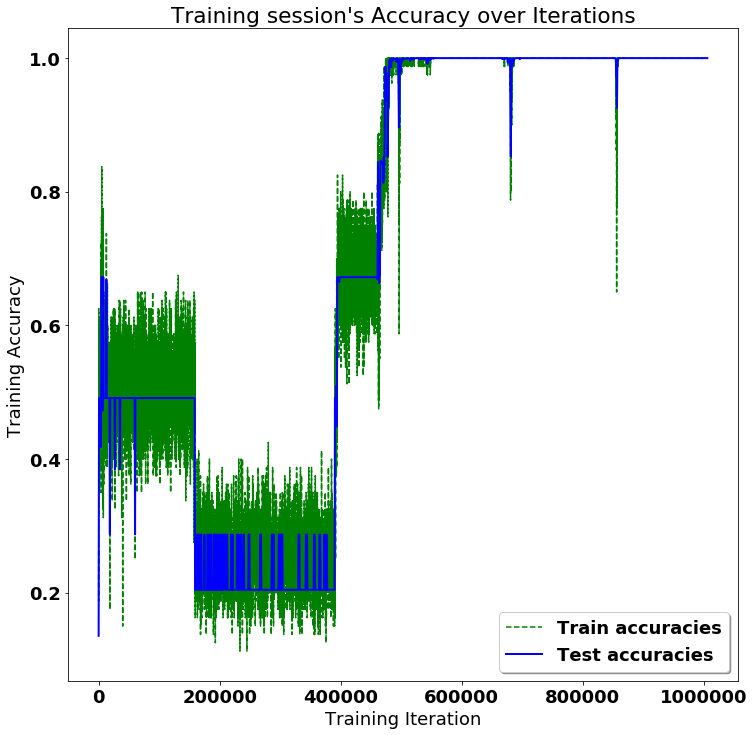

Testing Accuracy: 100.0%

Precision: 100.0%
Recall: 100.0%
f1_score: 100.0%

Confusion Matrix:
Created using test set of 3499 datapoints, normalised to % of each class in the test dataset


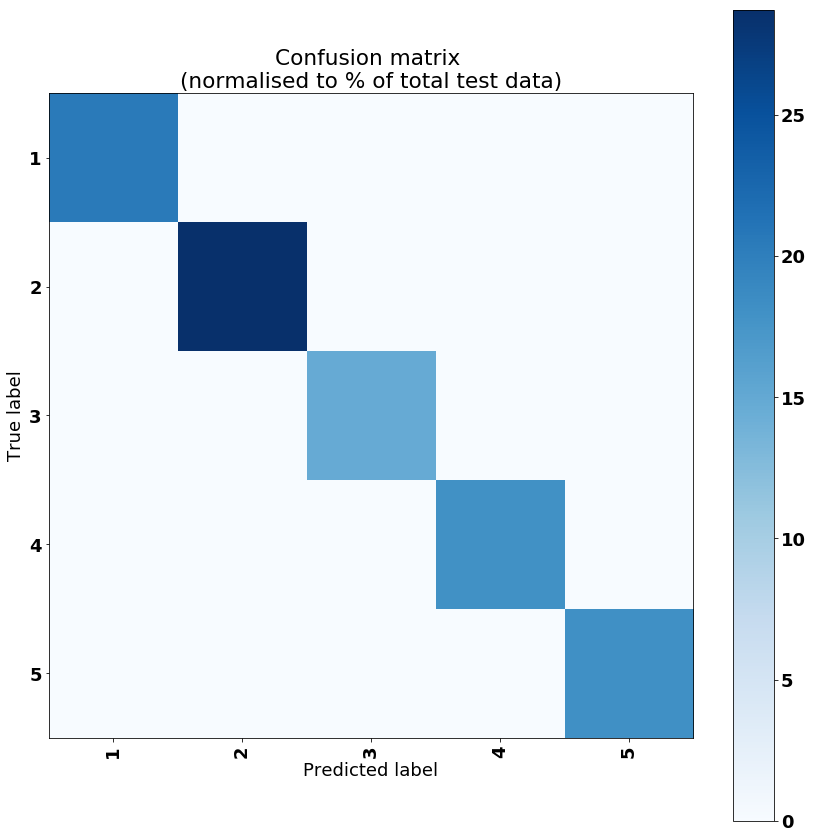

In [10]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [11]:
print(test_accuracies)

[0.13546728, 0.49099743, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.41811946, 0.67219204, 0.67219204, 0.67219204, 0.4721349, 0.591026, 0.67219204, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.6684767, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.2869391, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.38468134, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.38468134, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.49128324, 0.491283